In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime as dt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

### 1. データの読み込み 

In [2]:
df_kick = pd.read_csv("ks-projects-201801.csv")[['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']]
display(df_kick.head())
print(df_kick.describe())
print(df_kick.info())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


                 ID          goal       pledged        backers   usd pledged  \
count  3.786610e+05  3.786610e+05  3.786610e+05  378661.000000  3.748640e+05   
mean   1.074731e+09  4.908079e+04  9.682979e+03     105.617476  7.036729e+03   
std    6.190862e+08  1.183391e+06  9.563601e+04     907.185035  7.863975e+04   
min    5.971000e+03  1.000000e-02  0.000000e+00       0.000000  0.000000e+00   
25%    5.382635e+08  2.000000e+03  3.000000e+01       2.000000  1.698000e+01   
50%    1.075276e+09  5.200000e+03  6.200000e+02      12.000000  3.947200e+02   
75%    1.610149e+09  1.600000e+04  4.076000e+03      56.000000  3.034090e+03   
max    2.147476e+09  1.000000e+08  2.033899e+07  219382.000000  2.033899e+07   

       usd_pledged_real  usd_goal_real  
count      3.786610e+05   3.786610e+05  
mean       9.058924e+03   4.545440e+04  
std        9.097334e+04   1.152950e+06  
min        0.000000e+00   1.000000e-02  
25%        3.100000e+01   2.000000e+03  
50%        6.243300e+02   5.50000

In [3]:
#質的変数のユニークな要素を確認
clm = ['category','main_category', 'currency', 'state', 'country']
for i in clm:
    print('')
    print(i)
    print(df_kick[i].value_counts(dropna=False))


category
Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Printing               238
Makerspaces       

### 2.有効そうな変数を見つける
### 列方向(変数)
|変数|　|備考|
|-|-|-|
|ID|恐らく有効でない| |
|name|恐らく有効でない| |
|category|**有効そう**|要素数が多いので保留|
|main_category|**有効そう**|ダミー変数| |
|currency|**有効そう**|ダミー変数| |
|deadline|**そのままでは有効でなさそう**|期間に加工する| |
|goal|**有効そう**|usdに統一を利用| |
|launched|**そのままでは有効でなさそう**|期間に加工する| |
|pledged|事前予測不可| |
|**state**|**目的変数**|ダミー変数|
|backers|事前予測不可|   |
|country|**有効そう**|ダミー変数| |
|usd pledged|事前予測不可| |
|usd_pledged_real|事前予測不可| |
|usd_goal_real|**有効そう**|

### 行方向
#### 欠損
name、usd pledgedに欠損あり。  
→　今回は説明変数に含まないので考慮する必要なし。

#### 目的変数 state
failed、successful以外（canceled、undefined、live、suspended）  
→　成功するか(state)を事前に予測することが目的なのでひとまずfailedとして扱う。

### 3.前処理
### 3-1.ダミー変数化

In [4]:
# 質的変数をダミー変数に置きかえ
# 新しいDataFrameを作成
df_kick_day1 = pd.DataFrame(index=df_kick.index, columns=[])
#print(df_kick_day1)
var = ['main_category', 'currency', 'state', 'country'] 
for i in var:
    df_dum = pd.get_dummies(df_kick[i])
    df_kick_day1 = pd.concat([df_kick_day1, df_dum], axis=1)

df_kick_day1 = df_kick_day1.drop(['failed','canceled','undefined','live','suspended'], axis=1)
#print(df_kick_day1)

###  3-2.期間化（deadline, launched）

In [5]:
df_kick_day1['launched'] = pd.to_datetime(df_kick['launched'])
df_kick_day1['deadline'] = pd.to_datetime(df_kick['deadline'])
df_kick_day1['time'] = df_kick_day1['deadline'] - df_kick_day1['launched']
df_kick_day1['day'] = df_kick_day1['time'].dt.days
df_kick_day1 = df_kick_day1.drop(['launched','deadline','time'], axis=1)
#display(df_kick_day1.head())
#print(df_kick_day1.describe())
#print(df_kick_day1.info())

In [6]:
# そのまま使用する"usd_goal_real"を追加
df_kick_day1['usd_goal_real'] = df_kick['usd_goal_real']
display(df_kick_day1.head())
print(df_kick_day1.describe())
print(df_kick_day1.info())

,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,...,MX,"N,0""",NL,NO,NZ,SE,SG,US,day,usd_goal_real
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,58,1533.95
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,59,30000.00
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,44,45000.00
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,29,5000.00
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,55,19500.00


                 Art         Comics         Crafts          Dance  \
count  378661.000000  378661.000000  378661.000000  378661.000000   
mean        0.074349       0.028572       0.023264       0.009951   
std         0.262338       0.166600       0.150740       0.099257   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              Design        Fashion   Film & Video           Food  \
count  378661.000000  378661.000000  378661.000000  378661.000000   
mean        0.079411       0.060254       0.167921       0.064971   
std         0.270380       0.237958       0.373796       0.246475   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.0000

### 4.グラフを作成

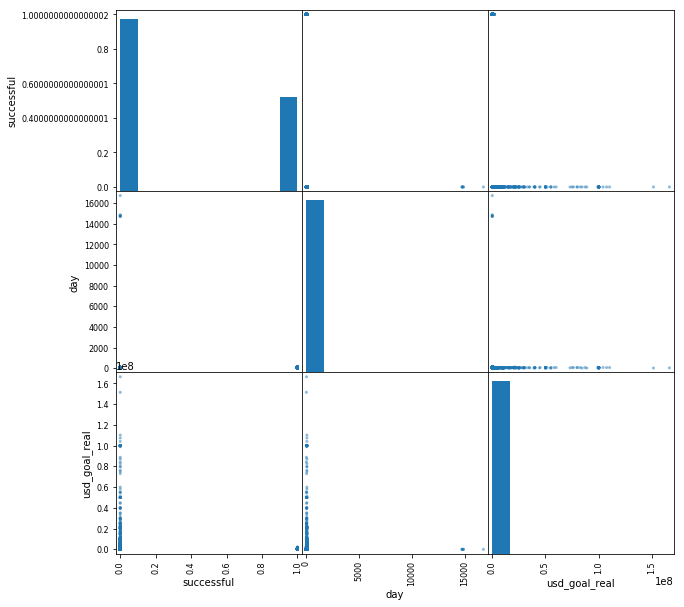

               successful       day  usd_goal_real
successful       1.000000 -0.026096      -0.023052
day             -0.026096  1.000000       0.004184
usd_goal_real   -0.023052  0.004184       1.000000


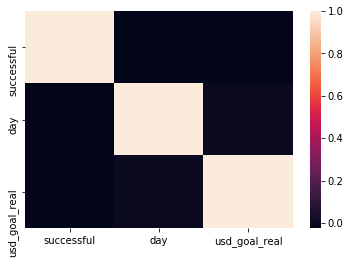

In [7]:
# 目的変数と量的変数について散布図行列、相関係数
pd.plotting.scatter_matrix(df_kick_day1[['successful','day','usd_goal_real']], figsize=(10,10))
plt.show()
print(df_kick_day1[['successful','day','usd_goal_real']].corr())
sns.heatmap(df_kick_day1[['successful','day','usd_goal_real']].corr())
plt.show()

### 5.ロジスティック回帰と識別精度
- 分類問題なのでロジスティック回帰を使用

In [8]:
y = df_kick_day1["successful"].values
X = df_kick_day1.drop('successful', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
# ラベルを予測
y_pred = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_pred)))

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「"successful"」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -14.980
正答率（Accuracy） = 56.629%
適合率（Precision） = 73.025%
再現率（Recall） = 52.152%
F1値（F1-score） = 60.848%


In [10]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,127619,117086
正解 = successful,47142,86814
